# **Sberbank house price prediction**

##**Base imports**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## **Loading the data**

In [ ]:
df_full_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_macro = pd.read_csv('data/macro.csv')

## **General data preparation**

In [ ]:
df_full_train.shape, df_test.shape

((30471, 292), (7662, 291))

In [ ]:
for df in [df_full_train, df_test]:
  df.columns = df.columns.str.lower().str.replace(' ','_')

In [ ]:
y_full_train = df_full_train['price_doc']
y_full_train.dtype

dtype('int64')

In [ ]:
del df_full_train['price_doc']

Lets check if column names in full train and test datasets match.

In [ ]:
print("Columns match exactly:", list(df_full_train.columns) == list(df_test.columns))

Columns match exactly: True


Lets check if data types in full train and test datasets match.

In [ ]:
train_dtypes = dict(df_full_train.dtypes)
test_dtypes = dict(df_test.dtypes)

print("Dtypes match by column:", train_dtypes == test_dtypes)

Dtypes match by column: False


In [ ]:
for col in df_full_train.columns:
    if df_full_train[col].dtype != df_test[col].dtype:
        print(f"{col}: train={df_full_train[col].dtype} vs test={df_test[col].dtype}")

full_sq: train=int64 vs test=float64
floor: train=float64 vs test=int64
max_floor: train=float64 vs test=int64
material: train=float64 vs test=int64
num_room: train=float64 vs test=int64


After identifying columns with unmatching data types we will convert them all to floats.

In [ ]:
for col in ['full_sq', 'floor', 'max_floor', 'material', 'num_room']:
    df_full_train[col] = df_full_train[col].astype('float64')
    df_test[col] = df_test[col].astype('float64')

In [ ]:
train_dtypes = dict(df_full_train.dtypes)
test_dtypes = dict(df_test.dtypes)

print("Dtypes match by column:", train_dtypes == test_dtypes)

Dtypes match by column: True


We see that there are a lot more numerical features in the data than categorical ones.

In [ ]:
categorical_col = list(df_full_train.dtypes[df_full_train.dtypes == 'object'].index)
len(categorical_col)

16

In [ ]:
numerical_col = list(df_full_train.dtypes[df_full_train.dtypes != 'object'].index)
len(numerical_col)

275

In [ ]:
for col in categorical_col:
  df_full_train[col] = df_full_train[col].str.lower().str.replace(' ','_')
  df_test[col] = df_test[col].str.lower().str.replace(' ','_')

Lets also check if there are any duplicate observations in the full train/test datasets.

In [ ]:
print("Any duplicates?", df_full_train.duplicated().any())

print("Number of duplicates:", df_full_train.duplicated().sum())

Any duplicates? False
Number of duplicates: 0


In [ ]:
print("Any duplicates?", df_test.duplicated().any())

print("Number of duplicates:", df_test.duplicated().sum())

Any duplicates? False
Number of duplicates: 0


We must keep in mind the temporal aspect of our data during further modeling. Train data is from mid 2011 to mid 2015 (4 years total) while test data is is from mid 2015 to mid 2016 (only one year total).

In [ ]:
df_full_train['timestamp'] = pd.to_datetime(df_full_train['timestamp'])
print("full train data date range:", df_full_train['timestamp'].min(), "to", df_full_train['timestamp'].max())

full train data date range: 2011-08-20 00:00:00 to 2015-06-30 00:00:00


In [ ]:
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
print("test data date range:", df_test['timestamp'].min(), "to", df_test['timestamp'].max())

test data date range: 2015-07-01 00:00:00 to 2016-05-30 00:00:00


## **Analyzing the target variable and features**

In [ ]:
df_full_train = pd.concat([df_full_train, y_full_train], axis=1)

In [ ]:
df_full_train.price_doc.describe().round()

,price_doc
count,30471.0
mean,7123035.0
std,4780111.0
min,100000.0
25%,4740002.0
50%,6274411.0
75%,8300000.0
max,111111112.0


In [ ]:
df_full_train.price_doc.isnull().sum()

np.int64(0)

The price range is very wide reaching a maximum of 111 million rubles while the minimum is only 1 million rubles. Obviously houses in Moscow could not have been so cheap (even in 2011) so we will remove those observations from the full train dataset

In [ ]:
df_full_train = df_full_train[df_full_train.price_doc > 1000000]

In [ ]:
print("full train data date range:", df_full_train['timestamp'].min(), "to", df_full_train['timestamp'].max())

full train data date range: 2011-08-20 00:00:00 to 2015-06-30 00:00:00


<Axes: xlabel='price_doc', ylabel='Count'>

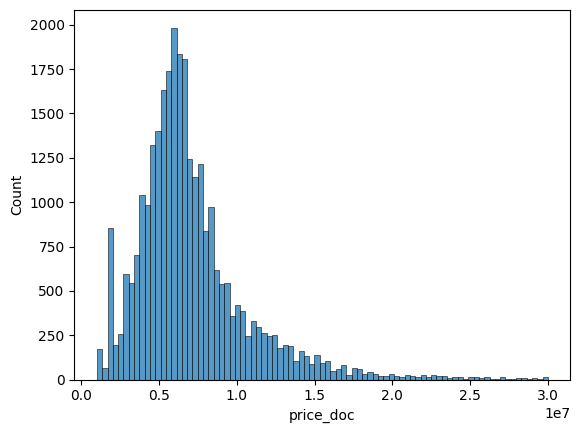

In [ ]:
sns.histplot(df_full_train.price_doc[df_full_train.price_doc <= 30000000], bins = 85)

The distribution of the target has a long tail to the right which is typical for house prices. We will apply the logarithmic transformation to make the distribution more symmetrical, this will help when training linear models.

In [ ]:
df_full_train['log_price_doc'] = np.log1p(df_full_train.price_doc)

<Axes: xlabel='log_price_doc', ylabel='Count'>

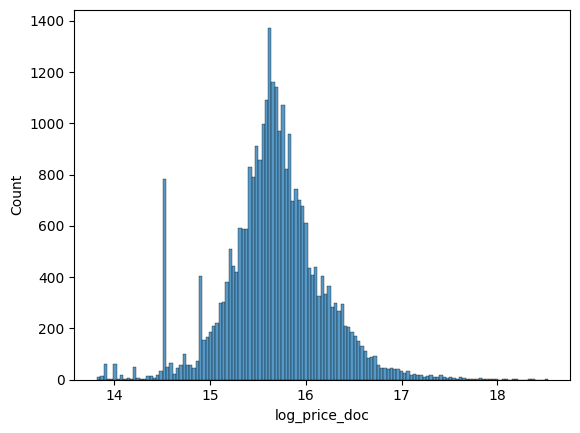

In [ ]:
sns.histplot(df_full_train.log_price_doc)

There is a total of 275 numerical features, some of which have a high count of NAs. Some features seem to be near exact copies of others ('metro_km_walk' and metro_min_walk').

In [ ]:
results = []

for col in numerical_col:
    train_null_count = df_full_train[col].isnull().sum()
    test_null_count = df_test[col].isnull().sum()
    train_null_pct = (train_null_count / len(df_full_train)) * 100
    test_null_pct = (test_null_count / len(df_test)) * 100

    results.append({
        'feature': col,
        'train_mean': round(df_full_train[col].mean(), 2),
        'train_std': round(df_full_train[col].std(), 2),
        'train_null': f"{train_null_count} ({train_null_pct:.1f}%)",
        'test_mean': round(df_test[col].mean(), 2),
        'test_std': round(df_test[col].std(), 2),
        'test_null': f"{test_null_count} ({test_null_pct:.1f}%)"
    })

stats_df = pd.DataFrame(results)
print(f"Numerical Features Summary ({len(numerical_col)} features)")
display(stats_df)

Numerical Features Summary (275 features)


,feature,train_mean,train_std,train_null,test_mean,test_std,test_null
0,id,15346.33,8763.20,0 (0.0%),34304.50,2211.97,0 (0.0%)
1,full_sq,54.45,38.53,0 (0.0%),53.70,20.10,0 (0.0%)
2,life_sq,34.67,53.31,6381 (21.6%),32.66,22.74,1176 (15.3%)
3,floor,7.71,5.34,160 (0.5%),7.65,5.10,0 (0.0%)
4,max_floor,12.59,6.79,9135 (31.0%),12.59,6.66,0 (0.0%)
5,material,1.83,1.48,9135 (31.0%),1.85,1.52,0 (0.0%)
6,build_year,3104.22,156929.93,13167 (44.6%),1820.89,552.99,1049 (13.7%)
7,num_room,1.91,0.85,9135 (31.0%),1.88,0.84,0 (0.0%)
8,kitch_sq,6.28,25.10,9135 (31.0%),6.94,25.58,0 (0.0%)
9,state,2.10,0.89,13082 (44.4%),1.99,0.82,694 (9.1%)


After analyzing the categorical features we can conclude that most features are low cardinality (except for 'sub_area') and that there are practically no missing values.

In [ ]:
cat_results = []

for col in categorical_col:
    train_vals = df_full_train[col].value_counts().head(3)
    test_vals = df_test[col].value_counts().head(3)

    cat_results.append({
        'feature': col,
        'nunique_train': df_full_train[col].nunique(),
        'nunique_test': df_test[col].nunique(),
        'top_3_train': [f"{k}({v})" for k, v in train_vals.items()],
        'top_3_test': [f"{k}({v})" for k, v in test_vals.items()],
        'null_train': df_full_train[col].isnull().sum(),
        'null_test': df_test[col].isnull().sum(),
    })

cat_stats_df = pd.DataFrame(cat_results)

print(f"Categorical Features Summary ({len(categorical_col)} features)")
display(cat_stats_df)

Categorical Features Summary (16 features)


,feature,nunique_train,nunique_test,top_3_train,top_3_test,null_train,null_test
0,timestamp,1160,274,"[2014-12-16 00:00:00(157), 2014-12-09 00:00:00...","[2016-01-25 00:00:00(80), 2016-02-02 00:00:00(...",0,0
1,product_type,2,2,"[investment(18470), owneroccupier(11021)]","[investment(4998), owneroccupier(2631)]",0,33
2,sub_area,145,145,"[poselenie_sosenskoe(1775), nekrasovka(1592), ...","[poselenie_vnukovskoe(584), poselenie_sosensko...",0,0
3,culture_objects_top_25,2,2,"[no(27612), yes(1879)]","[no(6971), yes(691)]",0,0
4,thermal_power_plant_raion,2,2,"[no(27925), yes(1566)]","[no(7248), yes(414)]",0,0
5,incineration_raion,2,2,"[no(27236), yes(2255)]","[no(7396), yes(266)]",0,0
6,oil_chemistry_raion,2,2,"[no(29210), yes(281)]","[no(7597), yes(65)]",0,0
7,radiation_raion,2,2,"[no(19118), yes(10373)]","[no(4864), yes(2798)]",0,0
8,railroad_terminal_raion,2,2,"[no(28370), yes(1121)]","[no(7344), yes(318)]",0,0
9,big_market_raion,2,2,"[no(26710), yes(2781)]","[no(7130), yes(532)]",0,0


## **Preparing the macro dataset**

We were also provided with a dataset containing information about the Russian economy between the years 2010 and 2016. Lets analyze this data and see what features we can extract for modeling.

In [ ]:
df_macro.columns = df_macro.columns.str.lower().str.replace(' ','_')

In [ ]:
df_macro['timestamp'] = pd.to_datetime(df_macro['timestamp'])
print("macro data date range:", df_macro['timestamp'].min(), "to", df_macro['timestamp'].max())

macro data date range: 2010-01-01 00:00:00 to 2016-10-19 00:00:00


In [ ]:
df_macro.shape

(2484, 100)

Since full train and test data timestamp range is from 2011-08-20 to 2016-05-30 we can clip the macro dataset to have the same timestamp range.

In [ ]:
df_macro = df_macro[(df_macro['timestamp'] >= '2011-08-20') & (df_macro['timestamp'] <= '2016-05-30')]
print("macro data date range:", df_macro['timestamp'].min(), "to", df_macro['timestamp'].max())

macro data date range: 2011-08-20 00:00:00 to 2016-05-30 00:00:00


In [ ]:
df_macro.shape

(1746, 100)

We will select the features below for modeling since they are the most suited for house price prediction from an economic point of view.

In [ ]:
macro_selected_col = ['gdp_quart', 'gdp_quart_growth', 'rts', 'micex',
                      'oil_urals','brent', 'cpi', 'ppi', 'usdrub', 'eurrub', 'net_capital_export',
                      'deposits_value', 'deposits_growth', 'deposits_rate', 'mortgage_value',
                      'mortgage_growth', 'mortgage_rate', 'fixed_basket', 'balance_trade',
                      'balance_trade_growth']

In [ ]:
df_macro = df_macro[ ['timestamp'] + macro_selected_col]

In [ ]:
macro_null_counts = df_macro.isnull().sum().sort_values(ascending=False)
macro_null_counts.head()

,0
timestamp,0
gdp_quart,0
gdp_quart_growth,0
rts,0
micex,0


In [ ]:
df_macro.dtypes

,0
timestamp,datetime64[ns]
gdp_quart,float64
gdp_quart_growth,float64
rts,float64
micex,float64
oil_urals,float64
brent,float64
cpi,float64
ppi,float64
usdrub,float64


Now we can merge the macro dataset with the full train/test datasets.

In [ ]:
df_full_train = df_full_train.merge(df_macro, on='timestamp', how='left')
df_test = df_test.merge(df_macro, on='timestamp', how='left')

## **Splitting the full train dataset into train and validation sets**

We must perform a temporal train-validation split in order to simulate the full train-test temporal split. This way we will be able to evaluate the models performance on newer data. Selecting a cut-off date equaling 2014-12-01 will split the full train data into train (84%) and validation (16%) sets.

In [ ]:
cutoff_date = pd.Timestamp('2014-12-01')
df_train = df_full_train[df_full_train['timestamp'] < cutoff_date].copy()
df_val = df_full_train[df_full_train['timestamp'] >= cutoff_date].copy().reset_index(drop=True)

In [ ]:
print(f"Train: {df_train.shape} | {df_train['timestamp'].min()} to {df_train['timestamp'].max()}")
print(f"Val:   {df_val.shape} | {df_val['timestamp'].min()} to {df_val['timestamp'].max()}")

Train: (24637, 313) | 2011-08-20 00:00:00 to 2014-11-29 00:00:00
Val:   (4854, 313) | 2014-12-01 00:00:00 to 2015-06-30 00:00:00


The distribution of the target variable is the same in the train and validation sets which means that we can continue further using this split.

<Axes: xlabel='log_price_doc', ylabel='Count'>

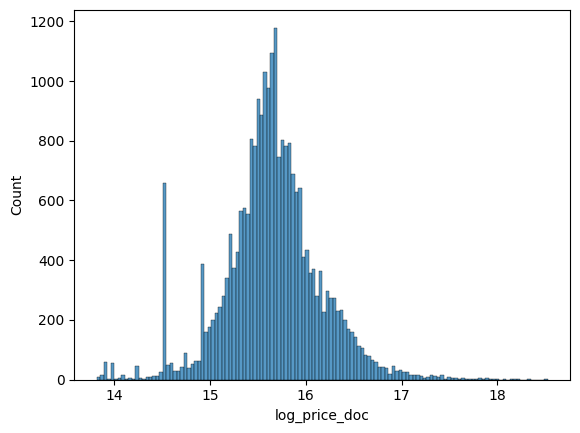

In [ ]:
sns.histplot(df_train.log_price_doc)

<Axes: xlabel='log_price_doc', ylabel='Count'>

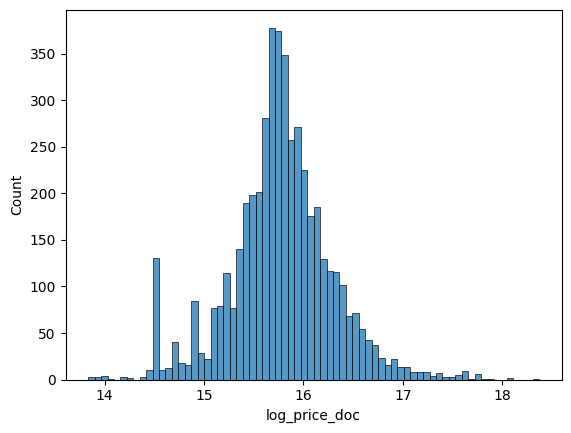

In [ ]:
sns.histplot(df_val.log_price_doc)

## **General feature selection**

We will select the features below for modeling since from an economic point of view they should have a strong effect on house prices.

In [ ]:
timestamp = ['timestamp']

categorical_col = ['sub_area',
                   'product_type',
                   'culture_objects_top_25',
                   'ecology']

numerical_col = ['floor','full_sq', 'green_zone_part', 'indust_part', 'preschool_quota', 'school_quota',
                      'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk',
                      'kindergarten_km', 'school_km', 'railroad_station_walk_km', 'railroad_station_walk_min',
                      'railroad_station_avto_km', 'railroad_station_avto_min', 'kremlin_km', 'preschool_km']

numerical_col = numerical_col + macro_selected_col

In [ ]:
target = ['log_price_doc']

target_rub = ['price_doc']

In [ ]:
df_train = df_train[timestamp + categorical_col + numerical_col + target + target_rub]
df_val = df_val[timestamp + categorical_col + numerical_col + target + target_rub]

In [ ]:
df_train.head()

,timestamp,sub_area,product_type,culture_objects_top_25,ecology,floor,full_sq,green_zone_part,indust_part,preschool_quota,school_quota,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,kremlin_km,preschool_km,gdp_quart,gdp_quart_growth,rts,micex,oil_urals,brent,cpi,ppi,usdrub,eurrub,net_capital_export,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,fixed_basket,balance_trade,balance_trade_growth,log_price_doc,price_doc
0,2011-08-20,bibirevo,investment,no,good,4.0,43.0,0.189727,0.000070,5001.0,11065.0,2.590241,1.131260,13.575119,1.131260,0.145700,0.177975,5.419893,65.038716,5.419893,6.905893,15.156211,0.177975,14313.7,3.3,1575.33,1438.74,109.31,108.62,354.0,420.7,29.0048,41.7681,0.301811,10618898,0.009740,4.1,323275,1.051914,11.84,12838.36,15.459,10.1,15.581952,5850000
1,2011-08-23,nagatinskij_zaton,investment,yes,excellent,3.0,34.0,0.372602,0.049637,3119.0,6237.0,0.936700,0.647337,7.620630,0.635053,0.147754,0.273345,3.411993,40.943917,3.641773,4.679745,8.698054,0.273345,14313.7,3.3,1578.91,1444.11,109.31,109.31,354.0,420.7,28.9525,41.7537,0.301811,10618898,0.009740,4.1,323275,1.051914,11.84,12838.36,15.459,10.1,15.607270,6000000
2,2011-08-27,tekstil'shhiki,investment,no,poor,2.0,43.0,0.112560,0.118537,1463.0,5580.0,2.120999,1.637996,17.351515,1.445960,0.049102,0.158072,1.277658,15.331896,1.277658,1.701420,9.067885,0.158072,14313.7,3.3,1596.17,1458.84,109.31,111.36,354.0,420.7,28.8082,41.7114,0.301811,10618898,0.009740,4.1,323275,1.051914,11.84,12838.36,15.459,10.1,15.555977,5700000
3,2011-09-01,mitino,investment,no,good,9.0,89.0,0.194703,0.069753,6839.0,17063.0,1.489049,0.984537,11.565624,0.963802,0.179441,0.236455,4.291432,51.497190,3.816045,5.271136,19.487005,0.236455,14313.7,3.3,1703.86,1551.58,111.29,114.29,353.2,434.4,28.9655,41.4014,0.599709,10720911,0.009607,4.0,386388,1.049543,11.92,12856.97,15.386,10.1,16.388123,13100000
4,2011-09-05,basmannoe,investment,no,excellent,4.0,77.0,0.015234,0.037316,3240.0,7770.0,1.257186,0.876620,8.266305,0.688859,0.247901,0.376838,0.853960,10.247521,1.595898,2.156284,2.578671,0.376838,14313.7,3.3,1617.01,1492.83,111.29,110.08,353.2,434.4,29.4625,41.5902,0.599709,10920215,0.018590,4.0,386388,1.049543,11.92,12856.97,15.386,10.1,16.608603,16331452


In [ ]:
df_val.head()

,timestamp,sub_area,product_type,culture_objects_top_25,ecology,floor,full_sq,green_zone_part,indust_part,preschool_quota,school_quota,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,kremlin_km,preschool_km,gdp_quart,gdp_quart_growth,rts,micex,oil_urals,brent,cpi,ppi,usdrub,eurrub,net_capital_export,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,fixed_basket,balance_trade,balance_trade_growth,log_price_doc,price_doc
0,2014-12-01,poselenie_vnukovskoe,investment,no,no_data,7.0,37.0,0.496315,0.007122,NaN,NaN,4.465559,2.323101,28.219726,2.351644,0.415160,0.816211,2.555463,30.665551,2.588880,4.064433,21.529480,0.816211,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,15.001614,3274297
1,2014-12-01,silino,investment,no,no_data,5.0,51.0,0.371990,0.136244,1427.0,2506.0,29.150027,23.009292,274.471941,22.872662,0.838223,0.209820,3.252284,39.027406,3.596140,5.677192,37.916336,0.209820,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,15.768538,7050000
2,2014-12-01,birjulevo_vostochnoe,investment,no,satisfactory,4.0,42.0,0.308057,0.050900,4519.0,10053.0,6.506044,8.179397,74.717919,6.226493,0.231183,0.274738,1.973046,23.676552,4.581773,5.438187,19.386285,0.274738,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,15.688174,6505600
3,2014-12-01,poselenie_sosenskoe,owneroccupier,no,no_data,21.0,36.0,0.336177,0.072158,NaN,NaN,7.581461,6.150010,73.800122,6.150010,3.602578,3.902133,10.037414,120.448965,13.560581,12.411964,21.609733,3.902133,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,15.312006,4466007
4,2014-12-01,poselenie_vnukovskoe,owneroccupier,no,no_data,14.0,40.0,0.496315,0.007122,NaN,NaN,2.596394,2.077115,24.925384,2.077115,1.170413,1.545730,4.090548,49.086573,4.090548,5.225926,22.222434,1.545730,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,15.542773,5625233


In [ ]:
df_train.shape, df_val.shape

((24637, 45), (4854, 45))

## **Filling missing values in the train and validation datasets**

In [ ]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

,0
preschool_quota,5287
school_quota,5285
floor,160
metro_km_walk,13
metro_min_walk,13
railroad_station_walk_km,13
railroad_station_walk_min,13
product_type,0
full_sq,0
ecology,0


In [ ]:
df_train['preschool_quota'] = df_train['preschool_quota'].fillna(df_train['preschool_quota'].median())
df_train['school_quota'] = df_train['school_quota'].fillna(df_train['school_quota'].median())

df_train['railroad_station_walk_km'] = df_train['railroad_station_walk_km'].fillna(df_train['railroad_station_walk_km'].median())
df_train['railroad_station_walk_min'] = df_train['railroad_station_walk_min'].fillna(df_train['railroad_station_walk_min'].median())

df_train['metro_km_walk'] = df_train['metro_km_walk'].fillna(df_train['metro_km_walk'].median())
df_train['metro_min_walk'] = df_train['metro_min_walk'].fillna(df_train['metro_min_walk'].median())

df_train['floor'] = df_train['floor'].fillna(df_train.floor.mode()[0])

In [ ]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

,0
timestamp,0
sub_area,0
product_type,0
culture_objects_top_25,0
ecology,0
floor,0
full_sq,0
green_zone_part,0
indust_part,0
preschool_quota,0


In [ ]:
df_val.isnull().sum().sort_values(ascending=False).head(10)

,0
preschool_quota,1384
school_quota,1383
railroad_station_walk_min,12
metro_km_walk,12
metro_min_walk,12
railroad_station_walk_km,12
culture_objects_top_25,0
floor,0
full_sq,0
ecology,0


In [ ]:
df_val['preschool_quota'] = df_val['preschool_quota'].fillna(df_train['preschool_quota'].median())
df_val['school_quota'] = df_val['school_quota'].fillna(df_train['school_quota'].median())

df_val['railroad_station_walk_km'] = df_val['railroad_station_walk_km'].fillna(df_train['railroad_station_walk_km'].median())
df_val['railroad_station_walk_min'] = df_val['railroad_station_walk_min'].fillna(df_train['railroad_station_walk_min'].median())

df_val['metro_km_walk'] = df_val['metro_km_walk'].fillna(df_train['metro_km_walk'].median())
df_val['metro_min_walk'] = df_val['metro_min_walk'].fillna(df_train['metro_min_walk'].median())


In [ ]:
df_val.isnull().sum().sort_values(ascending=False).head(10)

,0
timestamp,0
sub_area,0
product_type,0
culture_objects_top_25,0
ecology,0
floor,0
full_sq,0
green_zone_part,0
indust_part,0
preschool_quota,0


## **Feature engineering**

We will create three new features - 'season', 'floorbin' and 'days_since_start'. Later we will assess if these features have any predictive power.

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'fall'

In [ ]:
def get_floorbin(floor):
    if floor <= 1:
        return 'lower'
    elif floor <= 9:
        return 'standard'
    elif floor <= 20:
        return 'higher'
    else:
        return 'highest'

In [ ]:
df_train['season'] = df_train['timestamp'].dt.month.apply(get_season)
df_train['days_since_start'] = (df_train['timestamp'] - df_train['timestamp'].min()).dt.days
df_train['floorbin'] = df_train['floor'].apply(get_floorbin)

df_val['season'] = df_val['timestamp'].dt.month.apply(get_season)
df_val['days_since_start'] = (df_val['timestamp'] - df_train['timestamp'].min()).dt.days
df_val['floorbin'] = df_val['floor'].apply(get_floorbin)

In [ ]:
numerical_col = numerical_col + ['days_since_start']
numerical_col.remove('floor')
categorical_col = categorical_col + ['season'] + ['floorbin']

## **Precise Feature selection**

Our precise feature selection strategy follows a three-step approach to identify the most impactful predictors:

- ANOVA Testing - Statistical analysis to determine which categorical features significantly affect property prices

- Target Encoding - Transform categorical features using average prices per category for better model interpretation

- Correlation Analysis - Identify and remove highly correlated features to prevent multicollinearity, keeping only the most strongly correlated features with the target variable

This methodology ensures our model focuses on features that actually drive real estate values while maintaining statistical robustness and avoiding redundant predictors.

Step 1. We will perform ANOVA (Analysis of Variance) testing to identify which property characteristics actually affect home prices. This statistical test helps us determine which categorical features have significantly different average prices across categories. By focusing on the most influential features, we ensure our pricing model captures what truly drives real estate values in the market.

In [ ]:
from sklearn.feature_selection import f_regression

# Performing ANOVA F-test for each categorical feature
results = []

for col in categorical_col:
    # One-hot encoding the categorical feature
    X_encoded = pd.get_dummies(df_train[col].fillna('Missing'))

    # Performing the F-test
    f_scores, p_values = f_regression(X_encoded, df_train['log_price_doc'])

    # Storing the results
    results.append({
        'feature': col,
        'f_score': f_scores.mean(),
        'p_value': p_values.mean(),
        'n_categories': X_encoded.shape[1]
    })

# Creating results DataFrame and sorting by F-score
anova_results = pd.DataFrame(results)
anova_results = anova_results.sort_values('f_score', ascending=False)


anova_results.round(4)

,feature,f_score,p_value,n_categories
1,product_type,761.7009,0.0000,2
3,ecology,633.6559,0.0000,5
2,culture_objects_top_25,335.5249,0.0000,2
5,floorbin,91.5414,0.0000,4
0,sub_area,42.2501,0.1274,145
4,season,7.7490,0.0153,4


The results of ANOVA guided our feature selection as follows:

Features We Kept:
- product_type (F-score: 761.7) - Strongest predictor, indicating different pricing between property types

- ecology (F-score: 633.7) - Environmental factors significantly impact property values

- culture_objects_top_25 (F-score: 335.5) - Proximity to cultural landmarks drives price differences

- floorbin (F-score: 91.5) - Floor level grouping shows meaningful price variation

- sub_area (F-score: 42.3) - Despite statistical noise from 145 categories, location remains fundamentally important in real estate

Feature We Removed:
- season (F-score: 7.7) - Seasonal effects showed minimal practical impact on pricing and added unnecessary complexity

This balanced approach ensures our model captures the most impactful drivers of real estate values while maintaining simplicity and business relevance.

In [ ]:
df_train = df_train.drop(columns = 'season')
df_val = df_val.drop(columns = 'season')

categorical_col.remove('season')

Step 2. To proceed further with the analysis we must encode our categorical features. Target encoding is a technique for encoding categorical variables by replacing each category with the average value of the target variable for that category.

In [ ]:
from sklearn.preprocessing import TargetEncoder

encoder = TargetEncoder(
    target_type='continuous',
    smooth='auto')

In [ ]:
train_encoded_cats = encoder.fit_transform(
    df_train[categorical_col],
    df_train['log_price_doc']
)

In [ ]:
df_train_encoded = pd.DataFrame(train_encoded_cats)

new_column_names = []
for col in categorical_col:
    new_column_names.append(f'{col}_encoded')

df_train_encoded.columns = new_column_names

# Adding numerical columns
df_train_encoded[numerical_col] = df_train[numerical_col]

# Adding the target
df_train_encoded['price_doc'] = df_train['price_doc']
df_train_encoded['log_price_doc'] = df_train['log_price_doc']

In [ ]:
df_train_encoded.head()

,sub_area_encoded,product_type_encoded,culture_objects_top_25_encoded,ecology_encoded,floorbin_encoded,full_sq,green_zone_part,indust_part,preschool_quota,school_quota,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,kremlin_km,preschool_km,gdp_quart,gdp_quart_growth,rts,micex,oil_urals,brent,cpi,ppi,usdrub,eurrub,net_capital_export,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,fixed_basket,balance_trade,balance_trade_growth,days_since_start,price_doc,log_price_doc
0,15.693258,15.716031,15.634355,15.675612,15.638487,43.0,0.189727,0.000070,5001.0,11065.0,2.590241,1.131260,13.575119,1.131260,0.145700,0.177975,5.419893,65.038716,5.419893,6.905893,15.156211,0.177975,14313.7,3.3,1575.33,1438.74,109.31,108.62,354.0,420.7,29.0048,41.7681,0.301811,10618898,0.009740,4.1,323275,1.051914,11.84,12838.36,15.459,10.1,0,5850000,15.581952
1,15.832843,15.715687,15.882967,15.755416,15.637821,34.0,0.372602,0.049637,3119.0,6237.0,0.936700,0.647337,7.620630,0.635053,0.147754,0.273345,3.411993,40.943917,3.641773,4.679745,8.698054,0.273345,14313.7,3.3,1578.91,1444.11,109.31,109.31,354.0,420.7,28.9525,41.7537,0.301811,10618898,0.009740,4.1,323275,1.051914,11.84,12838.36,15.459,10.1,3,6000000,15.607270
2,15.654158,15.712890,15.634077,15.729686,15.634432,43.0,0.112560,0.118537,1463.0,5580.0,2.120999,1.637996,17.351515,1.445960,0.049102,0.158072,1.277658,15.331896,1.277658,1.701420,9.067885,0.158072,14313.7,3.3,1596.17,1458.84,109.31,111.36,354.0,420.7,28.8082,41.7114,0.301811,10618898,0.009740,4.1,323275,1.051914,11.84,12838.36,15.459,10.1,7,5700000,15.555977
3,15.955483,15.716031,15.634355,15.675612,15.638487,89.0,0.194703,0.069753,6839.0,17063.0,1.489049,0.984537,11.565624,0.963802,0.179441,0.236455,4.291432,51.497190,3.816045,5.271136,19.487005,0.236455,14313.7,3.3,1703.86,1551.58,111.29,114.29,353.2,434.4,28.9655,41.4014,0.599709,10720911,0.009607,4.0,386388,1.049543,11.92,12856.97,15.386,10.1,12,13100000,16.388123
4,16.057509,15.715687,15.634668,15.755416,15.637821,77.0,0.015234,0.037316,3240.0,7770.0,1.257186,0.876620,8.266305,0.688859,0.247901,0.376838,0.853960,10.247521,1.595898,2.156284,2.578671,0.376838,14313.7,3.3,1617.01,1492.83,111.29,110.08,353.2,434.4,29.4625,41.5902,0.599709,10920215,0.018590,4.0,386388,1.049543,11.92,12856.97,15.386,10.1,16,16331452,16.608603


In [ ]:
# Using the same encoder that was fitted on training data

val_encoded_cats = encoder.transform(df_val[categorical_col])

# Creating val DataFrame the same way
df_val_encoded = pd.DataFrame(val_encoded_cats)
df_val_encoded.columns = new_column_names  # Using the same column names

# Adding numerical columns
df_val_encoded[numerical_col] = df_val[numerical_col]

# Adding the target
df_val_encoded['price_doc'] = df_val['price_doc']
df_val_encoded['log_price_doc'] = df_val['log_price_doc']

In [ ]:
df_val_encoded.head()

,sub_area_encoded,product_type_encoded,culture_objects_top_25_encoded,ecology_encoded,floorbin_encoded,full_sq,green_zone_part,indust_part,preschool_quota,school_quota,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,kremlin_km,preschool_km,gdp_quart,gdp_quart_growth,rts,micex,oil_urals,brent,cpi,ppi,usdrub,eurrub,net_capital_export,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,fixed_basket,balance_trade,balance_trade_growth,days_since_start,price_doc,log_price_doc
0,15.550155,15.716267,15.635661,15.389157,15.638394,37.0,0.496315,0.007122,2854.0,7377.0,4.465559,2.323101,28.219726,2.351644,0.415160,0.816211,2.555463,30.665551,2.588880,4.064433,21.529480,0.816211,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,1199,3274297,15.001614
1,15.488200,15.716267,15.635661,15.389157,15.638394,51.0,0.371990,0.136244,1427.0,2506.0,29.150027,23.009292,274.471941,22.872662,0.838223,0.209820,3.252284,39.027406,3.596140,5.677192,37.916336,0.209820,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,1199,7050000,15.768538
2,15.506956,15.716267,15.635661,15.818883,15.638394,42.0,0.308057,0.050900,4519.0,10053.0,6.506044,8.179397,74.717919,6.226493,0.231183,0.274738,1.973046,23.676552,4.581773,5.438187,19.386285,0.274738,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,1199,6505600,15.688174
3,15.401069,15.533581,15.635661,15.389157,15.910869,36.0,0.336177,0.072158,2854.0,7377.0,7.581461,6.150010,73.800122,6.150010,3.602578,3.902133,10.037414,120.448965,13.560581,12.411964,21.609733,3.902133,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,1199,4466007,15.312006
4,15.550155,15.533581,15.635661,15.389157,15.685550,40.0,0.496315,0.007122,2854.0,7377.0,2.596394,2.077115,24.925384,2.077115,1.170413,1.545730,4.090548,49.086573,4.090548,5.225926,22.222434,1.545730,20406.9,0.9,958.33,1578.38,61.2833,72.54,440.5,510.1,51.6479,64.5124,-0.241395,18087076,0.022713,12.29,1528991,0.317269,12.62,16910.54,15.317,7.2,1199,5625233,15.542773


In [ ]:
df_train_encoded.shape, df_val_encoded.shape

((24637, 45), (4854, 45))

Step 3. Finally, we will perform the correlation analysis.

In [ ]:
corr_df = df_train_encoded.corrwith(df_train_encoded['log_price_doc'], method='spearman').abs().sort_values(ascending=False)
corr_df

,0
price_doc,1.000000
log_price_doc,1.000000
full_sq,0.524474
sub_area_encoded,0.515997
kremlin_km,0.361982
metro_km_walk,0.343314
metro_min_walk,0.343314
metro_km_avto,0.336171
metro_min_avto,0.322323
ecology_encoded,0.304641


From the correlation analysis we can conclude that the features most correlated with the target are:
- 'full_sq'
- 'sub_area_encoded'
- 'kremlin_km'
- 'metro_km_walk'
- 'metro_min_walk'
- 'metro_km_avto'
- 'metro_min_avto'
- 'ecology_encoded'

As stated earlier, some features seem to be near exact copies of others. Keeping two or more equivalent features (such as 'metro_km_walk', 'metro_min_walk') will only introduce noise into the model. Therefore we must perform a multicollinearity check.

In [ ]:
corr_matrix = df_train_encoded.corr(method = 'spearman')

pairs = []
features = corr_matrix.columns

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.95:                    # High multicollinearity threshold
            pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j],
                'target_corr1': corr_matrix.loc['log_price_doc', corr_matrix.columns[i]],
                'target_corr2': corr_matrix.loc['log_price_doc', corr_matrix.columns[j]]
            })


multicoll_df = pd.DataFrame(pairs)
multicoll_df

,feature1,feature2,correlation,target_corr1,target_corr2
0,metro_min_avto,metro_km_avto,0.963368,-0.322323,-0.336171
1,metro_km_avto,metro_min_walk,0.977426,-0.336171,-0.343314
2,metro_km_avto,metro_km_walk,0.977426,-0.336171,-0.343314
3,metro_min_walk,metro_km_walk,1.000000,-0.343314,-0.343314
4,school_km,preschool_km,0.964030,-0.220127,-0.213027
5,railroad_station_walk_km,railroad_station_walk_min,1.000000,-0.154710,-0.154710
6,railroad_station_avto_km,railroad_station_avto_min,0.964735,-0.156223,-0.169052
7,cpi,deposits_value,0.967113,0.133301,0.127889
8,cpi,fixed_basket,0.983489,0.133301,0.131044
9,cpi,days_since_start,0.999361,0.133301,0.133235


We used a correlation threshold of 0.95 to decide which features to drop.

In [ ]:
columns_to_drop = ['metro_min_avto',
                   'metro_km_avto',
                   'metro_min_walk',
                   'preschool_km',
                   'railroad_station_walk_km',
                   'railroad_station_avto_km',
                   'deposits_value',
                   'fixed_basket',
                   'days_since_start',
                   'eurrub']


df_train_encoded = df_train_encoded.drop(columns=columns_to_drop)

df_val_encoded = df_val_encoded.drop(columns=columns_to_drop)

In [ ]:
df_train_encoded.shape, df_val_encoded.shape

((24637, 35), (4854, 35))

In [ ]:
corr_matrix = df_train_encoded.corr(method = 'spearman')

pairs = []
features = corr_matrix.columns

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.95:
            pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j],
                'target_corr1': corr_matrix.loc['log_price_doc', corr_matrix.columns[i]],
                'target_corr2': corr_matrix.loc['log_price_doc', corr_matrix.columns[j]]
            })


multicoll_df = pd.DataFrame(pairs)
multicoll_df

,feature1,feature2,correlation,target_corr1,target_corr2
0,price_doc,log_price_doc,1.0,1.0,1.0


In [ ]:
corr_df = df_train_encoded.corrwith(df_train_encoded['log_price_doc'], method='spearman').abs().sort_values(ascending=False)
corr_df

,0
price_doc,1.000000
log_price_doc,1.000000
full_sq,0.524474
sub_area_encoded,0.515997
kremlin_km,0.361982
metro_km_walk,0.343314
ecology_encoded,0.304641
school_km,0.220127
product_type_encoded,0.208724
kindergarten_km,0.208189


We will select 11 features most strongly correlated with the target for further modeling.

In [ ]:
selected_cols = ['full_sq',
 'sub_area_encoded',
 'kremlin_km',
 'metro_km_walk',
 'ecology_encoded',
 'school_km',
 'product_type_encoded',
 'kindergarten_km',
 'railroad_station_avto_min',
 'usdrub',
 'cpi'
 ]

df_train_encoded = df_train_encoded[selected_cols + ['price_doc', 'log_price_doc']]
df_val_encoded = df_val_encoded[selected_cols + ['price_doc', 'log_price_doc']]

In [ ]:
df_train_encoded.head()

,full_sq,sub_area_encoded,kremlin_km,metro_km_walk,ecology_encoded,school_km,product_type_encoded,kindergarten_km,railroad_station_avto_min,usdrub,cpi,price_doc,log_price_doc
0,43.0,15.693258,15.156211,1.131260,15.675612,0.177975,15.716031,0.145700,6.905893,29.0048,354.0,5850000,15.581952
1,34.0,15.832843,8.698054,0.635053,15.755416,0.273345,15.715687,0.147754,4.679745,28.9525,354.0,6000000,15.607270
2,43.0,15.654158,9.067885,1.445960,15.729686,0.158072,15.712890,0.049102,1.701420,28.8082,354.0,5700000,15.555977
3,89.0,15.955483,19.487005,0.963802,15.675612,0.236455,15.716031,0.179441,5.271136,28.9655,353.2,13100000,16.388123
4,77.0,16.057509,2.578671,0.688859,15.755416,0.376838,15.715687,0.247901,2.156284,29.4625,353.2,16331452,16.608603


In [ ]:
df_val_encoded.head()

,full_sq,sub_area_encoded,kremlin_km,metro_km_walk,ecology_encoded,school_km,product_type_encoded,kindergarten_km,railroad_station_avto_min,usdrub,cpi,price_doc,log_price_doc
0,37.0,15.550155,21.529480,2.351644,15.389157,0.816211,15.716267,0.415160,4.064433,51.6479,440.5,3274297,15.001614
1,51.0,15.488200,37.916336,22.872662,15.389157,0.209820,15.716267,0.838223,5.677192,51.6479,440.5,7050000,15.768538
2,42.0,15.506956,19.386285,6.226493,15.818883,0.274738,15.716267,0.231183,5.438187,51.6479,440.5,6505600,15.688174
3,36.0,15.401069,21.609733,6.150010,15.389157,3.902133,15.533581,3.602578,12.411964,51.6479,440.5,4466007,15.312006
4,40.0,15.550155,22.222434,2.077115,15.389157,1.545730,15.533581,1.170413,5.225926,51.6479,440.5,5625233,15.542773


## **Baseline mean predictor**

To measure the real value of our machine learning approach, we'll first establish a simple reference point: we'll predict home prices based on the average price in each suburb. Any model we build should deliver better accuracy than this straightforward method.

In [ ]:
from sklearn.metrics import r2_score

def rmse(y_o, y_p):
  error = y_o - y_p
  se = error ** 2
  mse = se.mean()
  return np.sqrt(mse)

<Axes: ylabel='Count'>

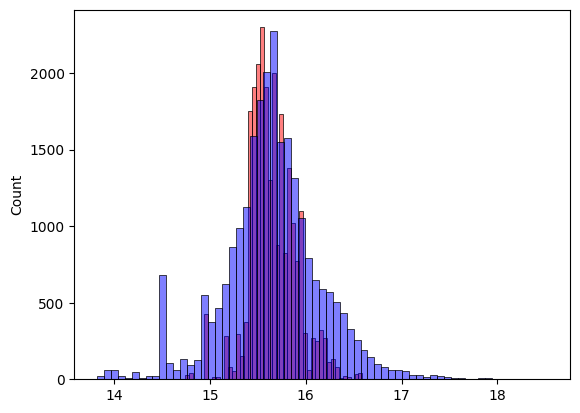

In [ ]:
y_train = df_train_encoded['log_price_doc'].values
y_pred_train = df_train_encoded.sub_area_encoded.values

sns.histplot(y_pred_train[y_pred_train < 30000000], color = 'red', alpha =0.5, bins = 65)
sns.histplot(y_train[y_train < 30000000], color = 'blue', alpha =0.5, bins = 65)

In [ ]:
print('RMSLE on train =', round(rmse(y_train, y_pred_train), 2))
print('RMSE on train =', round(rmse(np.expm1(y_train), np.expm1(y_pred_train)), 2))
print('R^2 score on train =', round(r2_score(y_train, y_pred_train) * 100, 2), '%')

RMSLE on train = 0.44
RMSE on train = 4098480.38
R^2 score on train = 23.16 %


<Axes: ylabel='Count'>

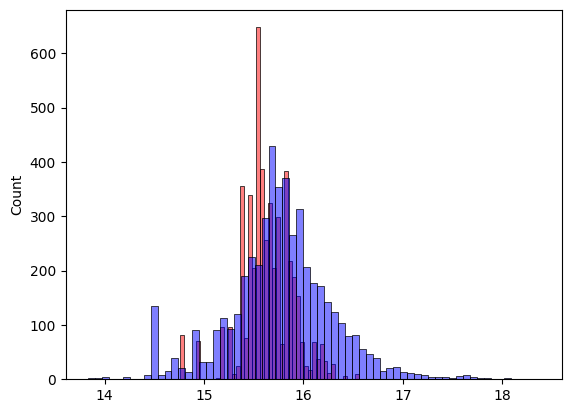

In [ ]:
y_val = df_val_encoded['log_price_doc'].values
y_pred_val = df_val_encoded.sub_area_encoded.values

sns.histplot(y_pred_val[y_pred_val < 30000000], color = 'red', alpha =0.5, bins = 65)
sns.histplot(y_val[y_val < 30000000], color = 'blue', alpha =0.5, bins = 65)

In [ ]:
print('RMSLE on val =', round(rmse(y_val, y_pred_val), 2))
print('RMSE on val =', round(rmse(np.expm1(y_val), np.expm1(y_pred_val)), 2))
print('R^2 score on val =', round(r2_score(y_val, y_pred_val) * 100, 2), '%')

RMSLE on val = 0.47
RMSE on val = 5171240.63
R^2 score on val = 20.77 %


Our baseline model achieved 0.47 RMSE on the validation set. All subsequent models must deliver lower RMSLE to demonstrate meaningful improvement.

## **Ridge regression model**

We will start with Ridge Regression, a stabilized version of linear regression that handles correlated features well. Because this algorithm is sensitive to the scale of features, we will also apply feature scaling to ensure optimal performance.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

X_train = df_train_encoded.drop(['price_doc', 'log_price_doc'], axis = 1).values
X_val = df_val_encoded.drop(['price_doc', 'log_price_doc'], axis = 1).values

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
feature_names = df_train_encoded.drop(['price_doc', 'log_price_doc'], axis = 1).columns.to_list()

In [ ]:
ridge = Ridge(alpha = 1.0, random_state = 42)
ridge.fit(X_train_scaled, y_train)

Ridge(random_state=42)

The intercept shows what the predicted price of a house will be when all features are at their mean values,
the price for a typical/average property in our dataset is approximately 6 263 685 rubles

In [ ]:
np.expm1(ridge.intercept_)

np.float64(6263684.769450774)

The Ridge regression coefficients reveal which features most influence property prices:

Strongest Positive Influences:
- sub_area_encoded (0.224) - Location is the strongest price driver, with premium areas commanding significantly higher prices

- full_sq (0.129) - Larger properties consistently sell for more, as expected

- cpi (0.066) - Economic factors like consumer price index affect market pricing

Strongest Negative Influences:
- kindergarten_km (-0.024) - Proximity to schools decreases prices (counterintuitive - may indicate urban vs suburban tradeoffs)

- kremlin_km (-0.020) - Distance from city center negatively impacts value

- product_type_encoded (-0.019) - Certain property types are associated with lower prices

The model successfully captures key real estate principles while revealing some nuanced market dynamics.

In [ ]:
coef_df = pd.DataFrame({'feature': feature_names,
                        'coefficient': ridge.coef_})
coef_df.round(6).sort_values('coefficient')

,feature,coefficient
7,kindergarten_km,-0.024854
2,kremlin_km,-0.020166
6,product_type_encoded,-0.019272
8,railroad_station_avto_min,-0.014927
9,usdrub,-0.001754
3,metro_km_walk,-0.001363
4,ecology_encoded,0.001906
5,school_km,0.012313
10,cpi,0.065373
0,full_sq,0.129298


<Axes: ylabel='Count'>

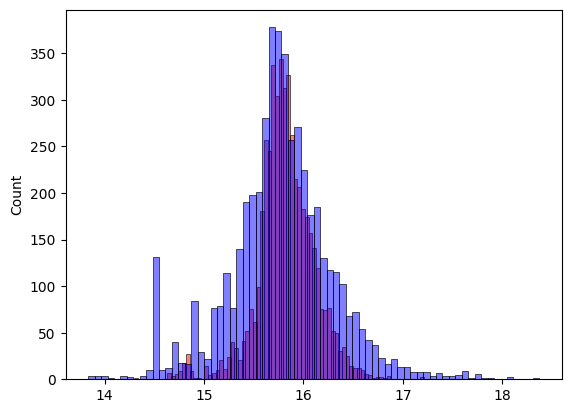

In [ ]:
y_pred_val = ridge.predict(X_val_scaled)

sns.histplot(y_pred_val, color = 'red', alpha =0.5)
sns.histplot(y_val, color = 'blue', alpha =0.5)

Ridge Regression achieves RMSLE of 0.42 on the validation set. This represents meaningful improvement over our area-mean baseline (0.47).

In [ ]:
print('RMSLE on val =', round(rmse(y_val, y_pred_val), 2))
print('RMSE on val =', round(rmse(np.expm1(y_val), np.expm1(y_pred_val)), 2))
print('R^2 score on val =', round(r2_score(y_val, y_pred_val) * 100, 2), '%')

RMSLE on val = 0.42
RMSE on val = 4371026.94
R^2 score on val = 37.81 %


<Axes: ylabel='Count'>

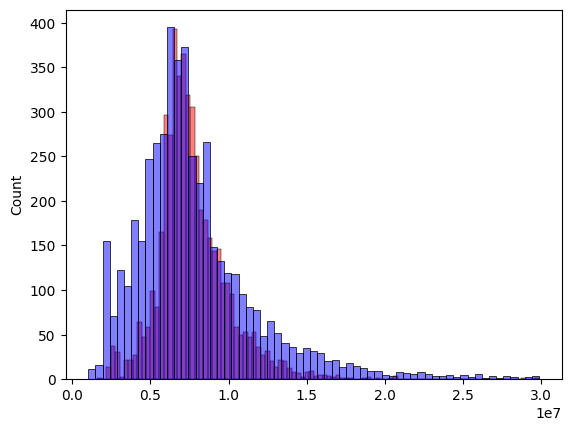

In [ ]:
y_val_rub = np.expm1(y_val)
y_pred_val_rub = np.expm1(y_pred_val)

sns.histplot(y_pred_val_rub[y_pred_val_rub < 30000000], color = 'red', alpha =0.5)
sns.histplot(y_val_rub[y_val_rub < 30000000], color = 'blue', alpha =0.5)

The model demonstrates robustness to regularization strength, we will chose the default alpha=1.0 for final Ridge implementation.

In [ ]:
scores = []

for a in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:

  ridge = Ridge(alpha = a, random_state=42)
  ridge.fit(X_train_scaled, y_train)

  y_pred_train = ridge.predict(X_train_scaled)
  y_pred_val = ridge.predict(X_val_scaled)

  rmse_log_train = rmse(y_train, y_pred_train)
  rmse_rub_train = rmse(np.expm1(y_train), np.expm1(y_pred_train))

  rmse_log_val = rmse(y_val, y_pred_val)
  rmse_rub_val = rmse(np.expm1(y_val), np.expm1(y_pred_val))


  scores.append((a, rmse_log_train, rmse_log_val, rmse_rub_train, rmse_rub_val))

In [ ]:
df_scores = pd.DataFrame(scores, columns = ['alpha', 'rmse_log_train', 'rmse_log_val', 'rmse_rub_train', 'rmse_rub_val'])
df_scores = df_scores.round({
    'alpha': 6,
    'rmse_log_train': 6,
    'rmse_log_val': 6,
    'rmse_rub_train': 0,
    'rmse_rub_val': 0
})

df_scores.sort_values('rmse_log_val')

,alpha,rmse_log_train,rmse_log_val,rmse_rub_train,rmse_rub_val
0,0.000001,0.419116,0.415450,5.612630e+11,4371018.0
1,0.000010,0.419116,0.415450,5.612630e+11,4371018.0
2,0.000100,0.419116,0.415450,5.612630e+11,4371018.0
3,0.001000,0.419116,0.415450,5.612627e+11,4371018.0
4,0.010000,0.419116,0.415450,5.612605e+11,4371019.0
5,0.100000,0.419116,0.415450,5.612378e+11,4371019.0
6,1.000000,0.419116,0.415451,5.610115e+11,4371027.0
7,10.000000,0.419116,0.415462,5.587532e+11,4371104.0
8,100.000000,0.419118,0.415573,5.366372e+11,4371939.0


## **Decision tree regressor model**

Having established an RMSLE of 0.42 with Ridge Regression, we will now leverage a Decision Tree model to capture the non-linear relationships in the housing data that a linear model might miss, hoping to improve RMSLE

By systematically evaluating tree depths, we identified the model's sweet spot at a depth of 7 to 9.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

for md in [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50, None]:

  dtr = DecisionTreeRegressor(max_depth=md, random_state=42)
  dtr.fit(X_train, y_train)

  y_pred_val = dtr.predict(X_val)

  score = rmse(y_val, y_pred_val)

  print(md,'-----',score.round(4))


1 ----- 0.4817
2 ----- 0.4393
3 ----- 0.4043
4 ----- 0.3816
5 ----- 0.3715
6 ----- 0.3649
7 ----- 0.3597
8 ----- 0.3561
9 ----- 0.3602
10 ----- 0.3727
15 ----- 0.4432
20 ----- 0.5153
25 ----- 0.5263
30 ----- 0.5372
35 ----- 0.4966
40 ----- 0.5237
45 ----- 0.5327
50 ----- 0.5327
None ----- 0.5327


Next we will tune the 'min_samples_leaf' parameter. As shown on the heatmap below, the value that gives the lowest RMSLE is 5, so our final Decision tree model will have a 'max_depth' of 9 and a 'min_samples_leaf' of 5. With these parameters we were able to achieve 0.352 RMSLE.

In [ ]:
scores = []

for md in [7, 8, 9]:
  for leaf in [1,2,5,10,15,20,100,200,500]:
     dtr = DecisionTreeRegressor(max_depth=md, min_samples_leaf=leaf, random_state=42)
     dtr.fit(X_train, y_train)

     y_pred_val = dtr.predict(X_val)

     score = rmse(y_val, y_pred_val)

     scores.append((md, leaf, score))


In [ ]:
col = ['max_depth', 'min_samples_leaf', 'score']
df_scores = pd.DataFrame(scores, columns = col)
df_scores.sort_values(by = 'score').head()

,max_depth,min_samples_leaf,score
20,9,5,0.352283
22,9,15,0.352977
21,9,10,0.353236
10,8,2,0.353262
11,8,5,0.353547


In [ ]:
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = ['max_depth'], values = ['score'])
df_scores_pivot

score                    
max_depth                7         8         9
min_samples_leaf                              
1                 0.359700  0.356118  0.360217
2                 0.358673  0.353262  0.358318
5                 0.358601  0.353547  0.352283
10                0.358989  0.357577  0.353236
15                0.359028  0.355782  0.352977
20                0.359818  0.359034  0.356397
100               0.361282  0.358488  0.357482
200               0.363743  0.361994  0.361671
500               0.374908  0.374680  0.374680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

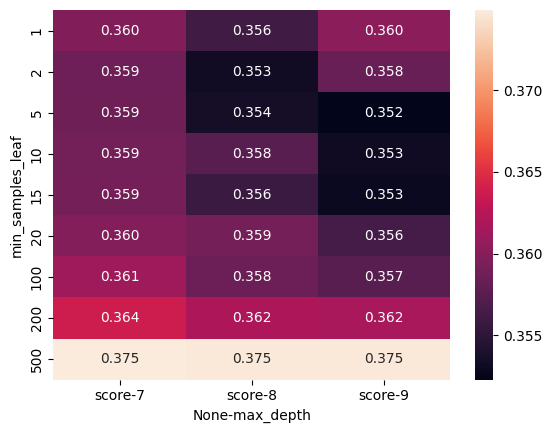

In [ ]:
sns.heatmap(df_scores_pivot, annot = True, fmt = '.3f')

The model's predictions are dominated by two features: 'full_sq' (living area) and 'sub_area_encoded' (district). This suggests that in our dataset, the apartment's size and its location are the most critical factors in determining price, with all other features providing only marginal predictive contributions.

In [ ]:
dtr = DecisionTreeRegressor(max_depth=9, min_samples_leaf=5, random_state=42)
dtr.fit(X_train, y_train)

importances = dtr.feature_importances_

feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


feature_imp_df

,feature,importance
0,full_sq,0.527384
1,sub_area_encoded,0.310300
2,kremlin_km,0.053453
10,cpi,0.024937
5,school_km,0.017886
3,metro_km_walk,0.017254
7,kindergarten_km,0.013907
8,railroad_station_avto_min,0.012322
6,product_type_encoded,0.010315
9,usdrub,0.008545


Text(0.5, 1.0, 'Decision Tree Visualization (First Three levels)')

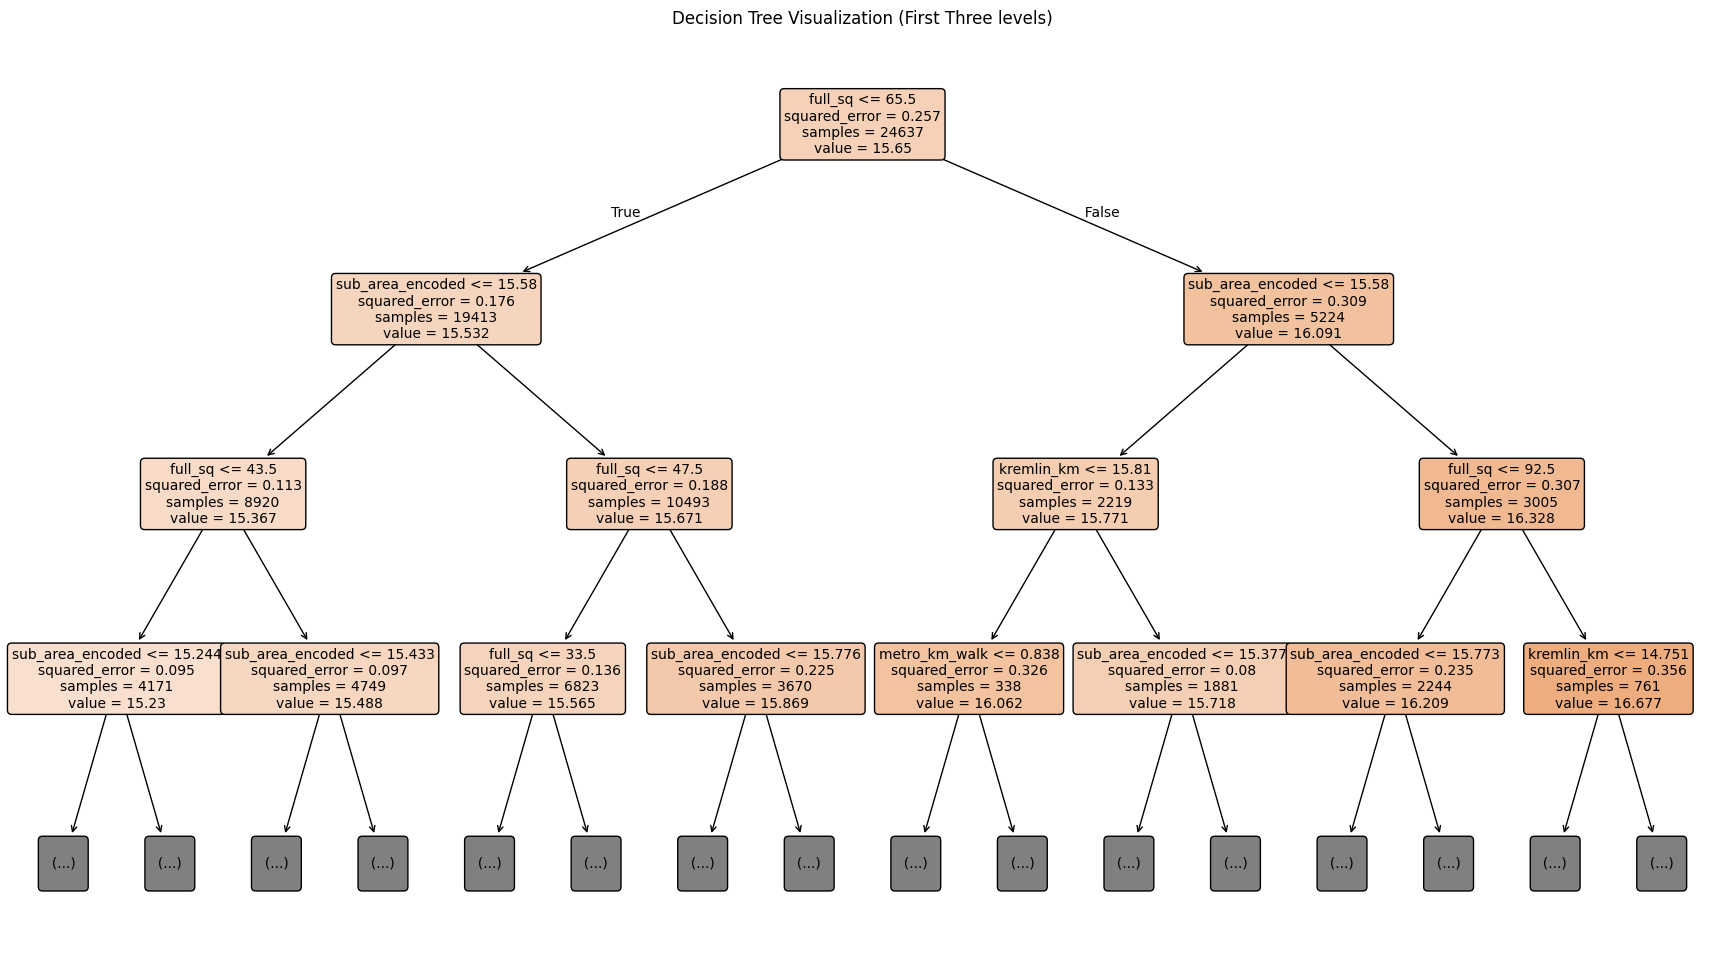

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(22, 12))
plot_tree(dtr,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          fontsize=10,
           max_depth=3)  # Limit depth for readability

plt.title("Decision Tree Visualization (First Three levels)")

Lets visualize the models predictions (below). The first plot shows our model's predictions in log scale closely aligning with the actual values, indicating a good overall fit. When converted back to rubles, the second plot reveals the model successfully captures the core distribution of apartment prices, though some divergence in the tails suggests room for improvement in predicting the most extreme values.

<Axes: ylabel='Count'>

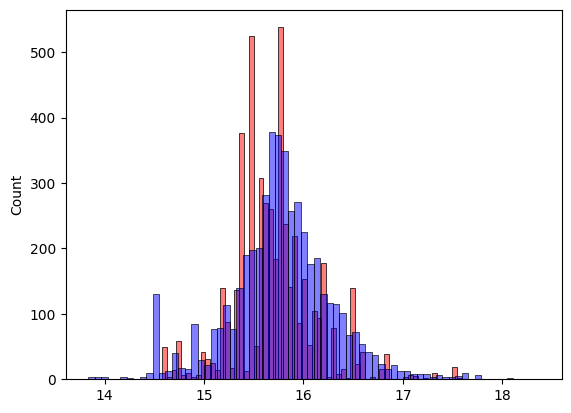

In [ ]:
y_pred_val = dtr.predict(X_val)

sns.histplot(y_pred_val, color = 'red', alpha =0.5)
sns.histplot(y_val, color = 'blue', alpha =0.5)

<Axes: ylabel='Count'>

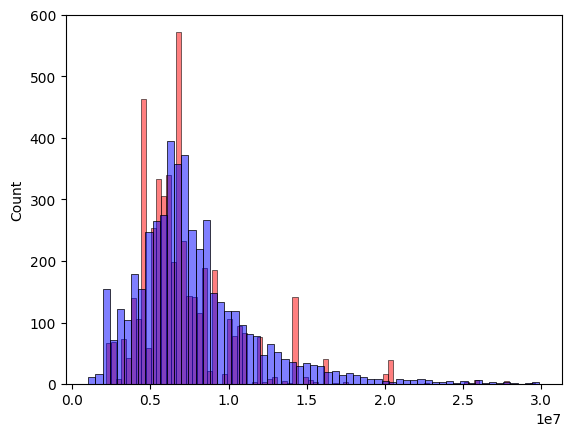

In [ ]:
y_pred_val_rub = np.expm1(y_pred_val)
y_val_rub = np.expm1(y_val)

sns.histplot(y_pred_val_rub[y_pred_val_rub <30000000], color = 'red', alpha =0.5)
sns.histplot(y_val_rub[y_val_rub <30000000], color = 'blue', alpha =0.5)

## **Random forest regressor model**

We will now move to a Random Forest Regressor. This ensemble method should improve our predictions by combining multiple trees to reduce overfitting and capture more complex patterns in the data.

A Random Forest with default parameters doesnt show much improvement in RMSLE after roughly 40 'n_estimators'.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

scores = []

rfr = RandomForestRegressor(random_state=42, warm_start=True)

for n in range(10, 201, 10):

  rfr.n_estimators = n
  rfr.fit(X_train, y_train)

  y_pred_val = rfr.predict(X_val)
  score = rmse(y_val, y_pred_val)

  scores.append((n, score))

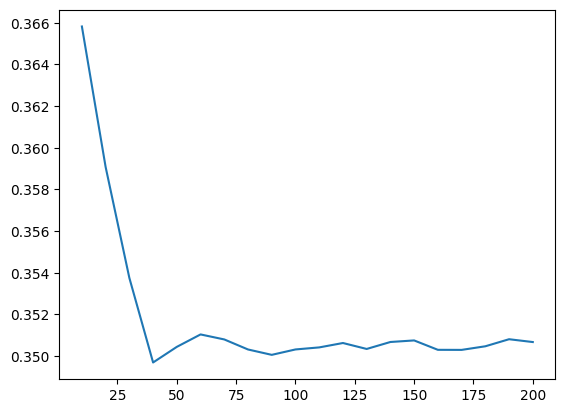

In [ ]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

Firstly, we will tune the 'max_depth' parameter of our Random Forest. We will test different 'max_depth' values while leveraging *warm_start=True* to progressively increase the number of estimators ('n_estimators'). This method allows us to observe how performance evolves as the forest grows, all without the computational overhead of rebuilding entire models from scratch for each tree count.

In [ ]:
scores = []

for md in [5, 10, 15, None]:
    # Creating one forest for this max_depth (using warm start for n_estimators loop)
    rfr = RandomForestRegressor(max_depth=md, warm_start=True, random_state=42)

    for n in range(10, 201, 10):
        rfr.n_estimators = n  # Just updating the tree count
        rfr.fit(X_train, y_train)  # Only building new trees

        y_pred_val = rfr.predict(X_val)
        score = rmse(y_val, y_pred_val)

        scores.append((md, n, score))

In [ ]:
col = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns = col)
df_scores.sort_values('rmse').head()

,max_depth,n_estimators,rmse
27,10.0,80,0.338729
32,10.0,130,0.338802
36,10.0,170,0.338876
33,10.0,140,0.338947
37,10.0,180,0.338957


As shown on the plot below, a forest with a 'max_depth' of 10 performs best (stops improving after 80 'n_estimators').

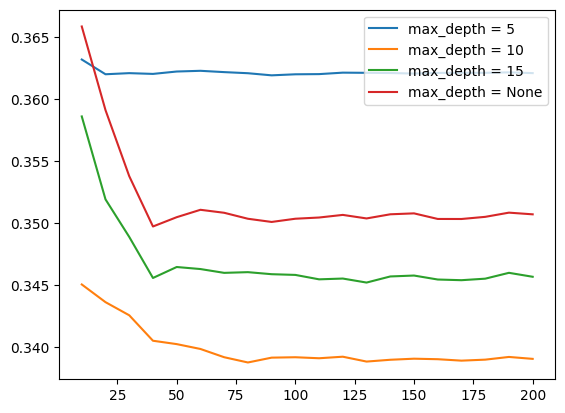

In [ ]:
for md in [5, 10, 15, None]:
    if md is None:
        df_subset = df_scores[df_scores.max_depth.isnull()]  # Use .isnull() for NaN
    else:
        df_subset = df_scores[df_scores.max_depth == md]

    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {md}')

plt.legend()

Secondly, we will tune the 'min_samples_leaf' parameter of the forest.

In [ ]:
scores = []

for leaf in [1, 3, 5, 10, 50]:
    # Creating one forest for this 'min_samples_leaf' (warm start for n_estimators loop)
    rfr = RandomForestRegressor(
        max_depth=10,
        min_samples_leaf=leaf,
        warm_start=True,
        random_state=42
    )

    for n in range(10, 301, 10):
        rfr.n_estimators = n  # Just updating tree count
        rfr.fit(X_train, y_train)  # Only building new trees

        y_pred_val = rfr.predict(X_val)
        score = rmse(y_val, y_pred_val)

        scores.append((leaf, n, score))

In [ ]:
col = ['min_samples_leaf', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns = col)
df_scores.sort_values('rmse').head()

,min_samples_leaf,n_estimators,rmse
89,5,300,0.335664
86,5,270,0.335724
85,5,260,0.335733
87,5,280,0.335741
88,5,290,0.335741


As shown on the plot below, a forest with  'min_samples_leaf' of 5 performs best (minimal RMSLE is achieved at 300 'n_estimators').

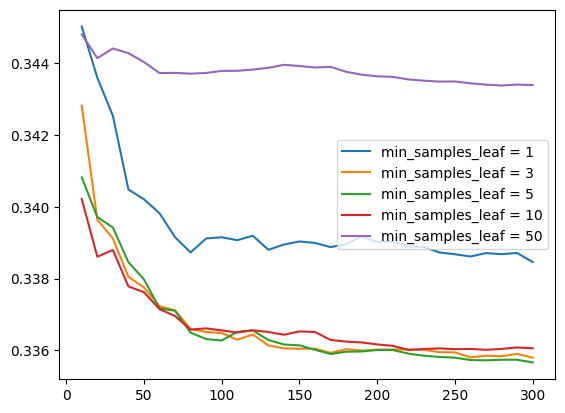

In [ ]:
for leaf in [1, 3, 5, 10, 50]:
  df_subset = df_scores[df_scores.min_samples_leaf == leaf]
  plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'min_samples_leaf = {leaf}')

plt.legend()

By leveraging an ensemble of trees, our Random Forest model successfully improved upon our previous benchmark, achieving a lower RMSLE of 0.336 compared to the single tree's 0.352. This confirms that aggregating predictions across multiple trees helps create a more accurate and generalizable model.

In [ ]:
rfr = RandomForestRegressor(n_estimators=300,
                            max_depth = 10,
                            min_samples_leaf=5,
                            random_state=42)

rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=300,
                      random_state=42)

Despite its increased complexity, the Random Forest's feature importance profile remains nearly identical to our single Decision Tree, confirming that apartment size and location are the overwhelmingly dominant price factors in this dataset.

In [ ]:
importances = rfr.feature_importances_

feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


feature_imp_df.head(15)

,feature,importance
0,full_sq,0.488843
1,sub_area_encoded,0.293668
2,kremlin_km,0.052878
5,school_km,0.028938
10,cpi,0.024518
7,kindergarten_km,0.023988
3,metro_km_walk,0.023830
9,usdrub,0.022027
8,railroad_station_avto_min,0.020513
6,product_type_encoded,0.013489


<Axes: ylabel='Count'>

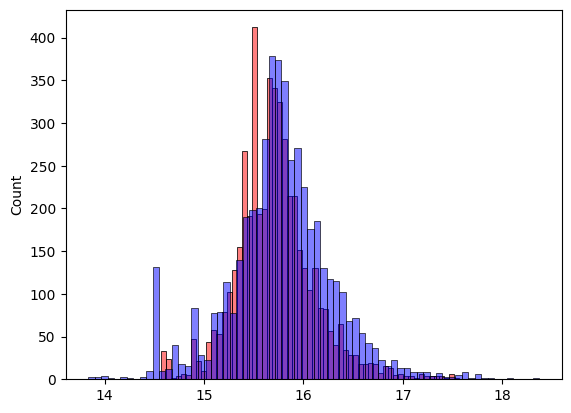

In [ ]:
y_pred_val = rfr.predict(X_val)

sns.histplot(y_pred_val, color = 'red', alpha =0.5)
sns.histplot(y_val, color = 'blue', alpha =0.5)

<Axes: ylabel='Count'>

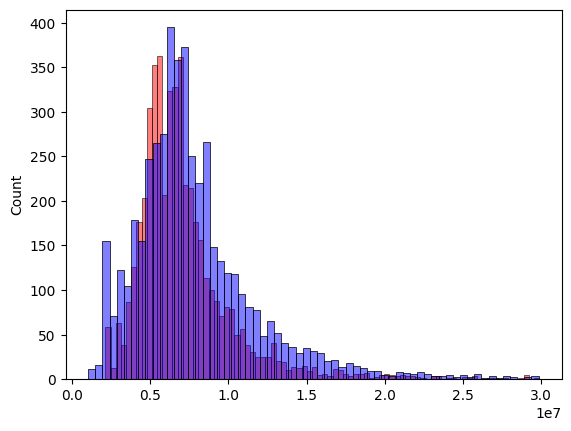

In [ ]:
y_pred_val_rub = np.expm1(y_pred_val)
y_val_rub = np.expm1(y_val)

sns.histplot(y_pred_val_rub[y_pred_val_rub <30000000], color = 'red', alpha =0.5)
sns.histplot(y_val_rub[y_val_rub <30000000], color = 'blue', alpha =0.5)

## **XGB Regressor model**

Building on the success of our Random Forest, we now advance to the XGBoost Regressor. This gradient boosting algorithm often delivers superior performance by sequentially correcting the errors of previous trees, offering a powerful tool to further optimize our prediction accuracy.

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y_train, feature_names= feature_names)
dval = xgb.DMatrix(X_val, label = y_val, feature_names= feature_names)

In [ ]:
xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weight' : 1,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dtrain, num_boost_round = 10)

In [ ]:
y_pred_val = model.predict(dval)

rmse(y_val, y_pred_val)

np.float64(0.33935285023559447)

XGBoost with its default parameters has already outperformed our single Decision Tree (0.352) and is highly competitive with our tuned Random Forest (0.336). This performance demonstrates the model's powerful learning capability and provides a foundation for further hyperparameter tuning.

To monitor our model's performance during training and guard against overfitting, we utilize XGBoost's built-in evaluation capability. By creating a watchlist and specifying an eval_metric, we can track the RMSLE for both the training and validation sets after each boosting round, giving us clear insight into the learning process.

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weight' : 1,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'rmse',

}

model = xgb.train(xgb_params,dtrain,
                  num_boost_round = 200,
                  evals = watchlist,
                  verbose_eval = 5) #we will see the rmse for every fifth tree built (instead of seeing all of them)

In [ ]:
print(output)

[0]	train-rmse:0.43466	val-rmse:0.45987
[5]	train-rmse:0.33622	val-rmse:0.34947
[10]	train-rmse:0.32205	val-rmse:0.33780
[15]	train-rmse:0.31330	val-rmse:0.33537
[20]	train-rmse:0.30709	val-rmse:0.33556
[25]	train-rmse:0.30178	val-rmse:0.33637
[30]	train-rmse:0.29646	val-rmse:0.33722
[35]	train-rmse:0.29213	val-rmse:0.33777
[40]	train-rmse:0.28690	val-rmse:0.33866
[45]	train-rmse:0.28154	val-rmse:0.33825
[50]	train-rmse:0.27694	val-rmse:0.33845
[55]	train-rmse:0.27250	val-rmse:0.33863
[60]	train-rmse:0.26791	val-rmse:0.33923
[65]	train-rmse:0.26430	val-rmse:0.33932
[70]	train-rmse:0.25965	val-rmse:0.33990
[75]	train-rmse:0.25609	val-rmse:0.34069
[80]	train-rmse:0.25240	val-rmse:0.34283
[85]	train-rmse:0.24884	val-rmse:0.34204
[90]	train-rmse:0.24519	val-rmse:0.34260
[95]	train-rmse:0.24115	val-rmse:0.34246
[100]	train-rmse:0.23802	val-rmse:0.34300
[105]	train-rmse:0.23409	val-rmse:0.34366
[110]	train-rmse:0.23001	val-rmse:0.34417
[115]	train-rmse:0.22686	val-rmse:0.34574
[120]	train-rm

In [ ]:
def parse_xgb_output(output):
  results = []

  for line in output.stdout.strip().split('\n'):
    num_iter, train_rmse, val_rmse = line.split('\t')

    iter = int(num_iter.strip('[]'))
    train = float(train_rmse.split(':')[1])
    val = float(val_rmse.split(':')[1])

    results.append((iter, train, val))


  col = ['num_iter', 'train_rmse', 'val_rmse']
  df_results = pd.DataFrame(results, columns = col)
  return df_results

In [ ]:
df_scores = parse_xgb_output(output)
df_scores.sort_values('val_rmse').head()

,num_iter,train_rmse,val_rmse
3,15,0.31330,0.33537
4,20,0.30709,0.33556
5,25,0.30178,0.33637
6,30,0.29646,0.33722
7,35,0.29213,0.33777


Our model with default parameters starts overfitting after 15 iterations.

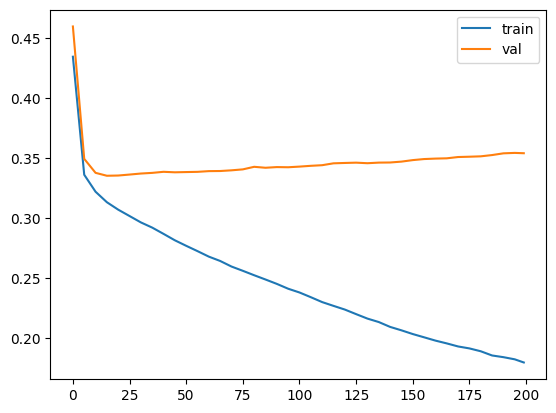

In [ ]:
plt.plot(df_scores.num_iter, df_scores.train_rmse, label = 'train')
plt.plot(df_scores.num_iter, df_scores.val_rmse, label = 'val')

plt.legend()

To systematically find the optimal learning rate, we will evaluate a range of candidate values: [0.01, 0.05, 0.1, 0.3]. The process involves training a separate model for each eta value and storing the resulting performance metrics in a dictionary for easy comparison and analysis.

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.05,
    'max_depth': 6,
    'min_child_weight' : 1,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'rmse',

}

model = xgb.train(xgb_params,dtrain,
                  num_boost_round = 500,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

In [ ]:
scores.keys()

dict_keys(['eta=0.1', 'eta=0.3', 'eta=1.0', 'eta=0.01', 'eta=0.05'])

(0.0, 300.0)

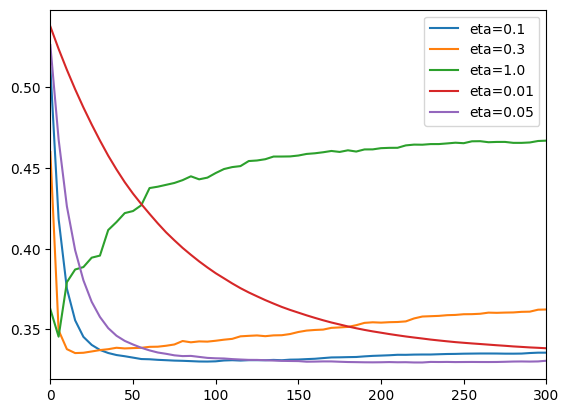

In [ ]:
for key, df in scores.items():
  plt.plot(df.num_iter, df.val_rmse, label = key)
plt.legend()
plt.xlim(0, 300)

In [ ]:
scores['eta=0.05'].sort_values('val_rmse').head()

,num_iter,train_rmse,val_rmse
45,225,0.28869,0.32955
44,220,0.28942,0.32956
39,195,0.29380,0.32964
38,190,0.29491,0.32967
42,210,0.29111,0.32968


With the optimal learning rate (eta) of 0.05 established, we now proceed to tune the model's complexity by evaluating different max_depth values (we will try 3, 4, 6, 10)

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 1,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'rmse',

}

model = xgb.train(xgb_params,dtrain,
                  num_boost_round = 500,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

In [ ]:
scores.keys()

dict_keys(['max_depth=10', 'max_depth=6', 'max_depth=3', 'max_depth=4'])

(0.32, 0.375)

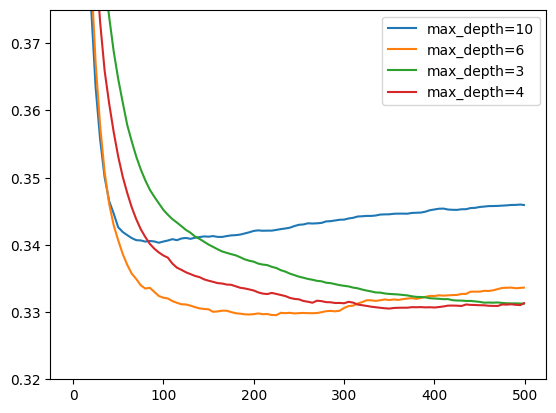

In [ ]:
for key, df in scores.items():
  plt.plot(df.num_iter, df.val_rmse, label = key)
plt.legend()
plt.ylim(0.32, 0.375)

In [ ]:
scores['max_depth=4'].sort_values('val_rmse').head()

,num_iter,train_rmse,val_rmse
70,350,0.31730,0.33052
69,345,0.31754,0.33057
71,355,0.31708,0.33061
68,340,0.31784,0.33064
72,360,0.31682,0.33064


Having selected an optimal max_depth of 4, we now refine the model further by tuning the min_child_weight parameter (we will try 1, 5, 10, 30).

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 10,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'rmse',

}

model = xgb.train(xgb_params,dtrain,
                  num_boost_round = 500,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [ ]:
scores.keys()

dict_keys(['min_child_weight=30', 'min_child_weight=10', 'min_child_weight=1', 'min_child_weight=5'])

(0.325, 0.345)

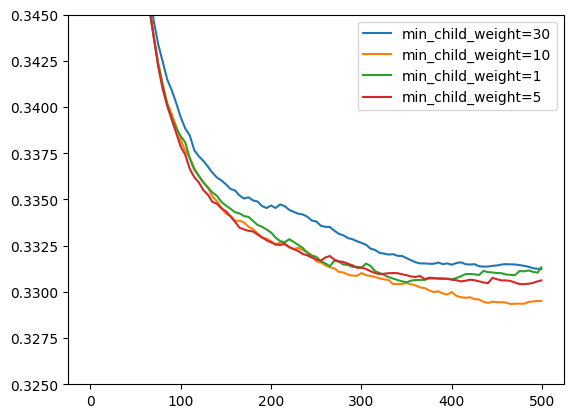

In [ ]:
for key, df in scores.items():
  plt.plot(df.num_iter, df.val_rmse, label = key)
plt.legend()

plt.ylim(0.325, 0.345)

In [ ]:
scores['min_child_weight=10'].sort_values('val_rmse').head()

,num_iter,train_rmse,val_rmse
93,465,0.31434,0.32934
96,480,0.31365,0.32936
94,470,0.31403,0.32936
95,475,0.31384,0.32936
88,440,0.31544,0.32940


After systematic tuning of key hyperparameters, we have arrived at our final XGBoost configuration. The model, which uses a conservative learning rate (eta=0.05) paired with moderate tree depth (max_depth=4) and regularization (min_child_weight = 10), achieves its optimal performance at 465 boosting rounds. We were able to achieve a RMSLE of 0.329 on the validation set, this is the best result so far across all models, meaning that we will select XGB as our final model

In [ ]:
xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 10,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'rmse',

}

model = xgb.train(xgb_params,dtrain,
                  num_boost_round = 465)

model

Our final XGBoost model reveals a more nuanced feature importance profile compared to our previous models. While full_sq remains the dominant predictor, its lead is less absolute, and the model now leverages a broader set of location-based features like kremlin_km and sub_area_encoded more evenly, suggesting it has learned a more complex and distributed pattern for price prediction.

In [ ]:
importances = model.get_score(importance_type='weight')

feature_imp_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
})

feature_imp_df.sort_values('importance', ascending=False)

,feature,importance
0,full_sq,1058.0
1,sub_area_encoded,743.0
2,kremlin_km,704.0
7,kindergarten_km,623.0
8,railroad_station_avto_min,601.0
5,school_km,580.0
3,metro_km_walk,518.0
6,product_type_encoded,343.0
10,cpi,330.0
9,usdrub,329.0


<Axes: ylabel='Count'>

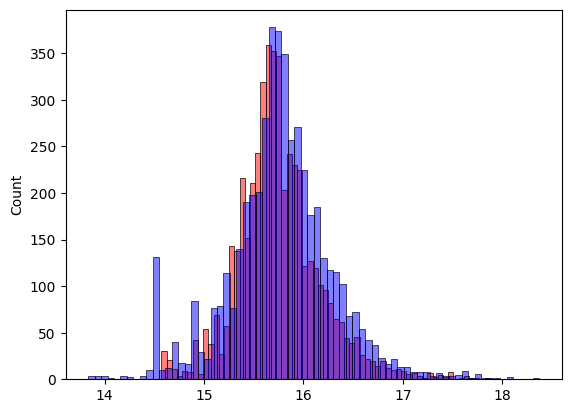

In [ ]:
y_pred_val = model.predict(dval)

sns.histplot(y_pred_val, color = 'red', alpha =0.5)
sns.histplot(y_val, color = 'blue', alpha =0.5)

In [ ]:
rmse(y_val, y_pred_val)

np.float64(0.329379555429944)

<Axes: ylabel='Count'>

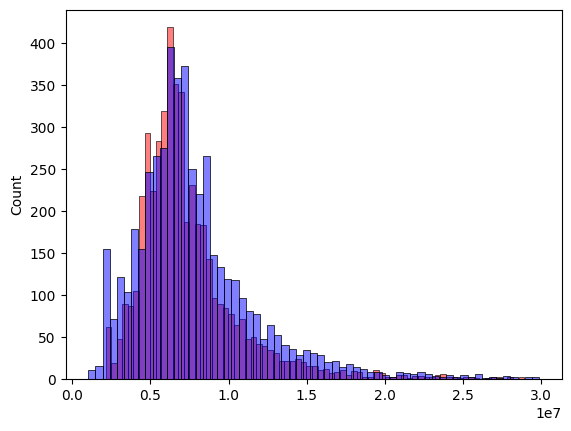

In [ ]:
y_pred_val_rub = np.expm1(y_pred_val)
y_val_rub = np.expm1(y_val)

sns.histplot(y_pred_val_rub[y_pred_val_rub <30000000], color = 'red', alpha =0.5)
sns.histplot(y_val_rub[y_val_rub <30000000], color = 'blue', alpha =0.5)

In [ ]:
rmse(y_val_rub, y_pred_val_rub)

np.float64(2839445.5084144827)

## **Competition submission**

To create our competition submission, we will now train the final XGBoost model on the entire combined training set (training + validation data). It's crucial that we apply the exact same preprocessing pipeline to this full dataset and the test set to ensure consistent feature engineering and reliable predictions.

- Feature selection:

In [ ]:
categorical_col = ['sub_area',
                   'ecology',
                   'product_type']

numerical_col = ['full_sq',
                 'kremlin_km',
                 'metro_km_walk',
                 'school_km',
                 'kindergarten_km',
                 'railroad_station_avto_min',
                 'usdrub',
                 'cpi']

In [ ]:
target = ['log_price_doc']

target_rub = ['price_doc']

test_ids = df_test['id']

In [ ]:
df_full_train = df_full_train[categorical_col + numerical_col + target + target_rub]
df_test = df_test[categorical_col + numerical_col]

In [ ]:
df_full_train.head()

,sub_area,ecology,product_type,full_sq,kremlin_km,metro_km_walk,school_km,kindergarten_km,railroad_station_avto_min,usdrub,cpi,log_price_doc,price_doc
0,bibirevo,good,investment,43.0,15.156211,1.131260,0.177975,0.145700,6.905893,29.0048,354.0,15.581952,5850000
1,nagatinskij_zaton,excellent,investment,34.0,8.698054,0.635053,0.273345,0.147754,4.679745,28.9525,354.0,15.607270,6000000
2,tekstil'shhiki,poor,investment,43.0,9.067885,1.445960,0.158072,0.049102,1.701420,28.8082,354.0,15.555977,5700000
3,mitino,good,investment,89.0,19.487005,0.963802,0.236455,0.179441,5.271136,28.9655,353.2,16.388123,13100000
4,basmannoe,excellent,investment,77.0,2.578671,0.688859,0.376838,0.247901,2.156284,29.4625,353.2,16.608603,16331452


In [ ]:
df_test.head()

,sub_area,ecology,product_type,full_sq,kremlin_km,metro_km_walk,school_km,kindergarten_km,railroad_station_avto_min,usdrub,cpi
0,juzhnoe_butovo,satisfactory,investment,39.0,24.779082,0.735908,0.746962,0.078502,6.274963,55.5989,490.5
1,poselenie_vnukovskoe,no_data,owneroccupier,79.2,21.722620,3.444625,1.332570,1.192193,6.859956,55.5989,490.5
2,perovo,poor,investment,40.5,10.320728,1.122214,0.194608,0.065324,5.375048,55.5989,490.5
3,poselenie_voskresenskoe,no_data,owneroccupier,62.8,26.960463,5.713316,3.540105,3.189083,13.517419,55.5989,490.5
4,poselenie_vnukovskoe,no_data,owneroccupier,40.0,21.905792,1.722233,1.234235,0.897889,4.782323,55.5989,490.5


In [ ]:
df_full_train.shape, df_test.shape

((29491, 13), (7662, 11))

- Filling NAs:

In [ ]:
df_full_train.isnull().sum().sort_values(ascending=False).head()

,0
metro_km_walk,25
ecology,0
product_type,0
full_sq,0
sub_area,0


In [ ]:
df_full_train['metro_km_walk'] = df_full_train['metro_km_walk'].fillna(df_full_train['metro_km_walk'].median())

In [ ]:
df_full_train.isnull().sum().sort_values(ascending=False).head()

,0
sub_area,0
ecology,0
product_type,0
full_sq,0
kremlin_km,0


In [ ]:
df_test.isnull().sum().sort_values(ascending=False).head(10)

,0
metro_km_walk,34
product_type,33
sub_area,0
ecology,0
full_sq,0
kremlin_km,0
school_km,0
kindergarten_km,0
railroad_station_avto_min,0
usdrub,0


In [ ]:
df_test['metro_km_walk'] = df_test['metro_km_walk'].fillna(df_full_train['metro_km_walk'].median())
df_test['product_type'] = df_test['product_type'].fillna(df_full_train.product_type.mode()[0])

In [ ]:
df_test.isnull().sum().sort_values(ascending=False).head()

,0
sub_area,0
ecology,0
product_type,0
full_sq,0
kremlin_km,0


Before final model training, we performed a quick sanity check by re-running ANOVA tests and correlation analysis on the complete training dataset. This confirmed that our feature importance rankings and relationships remained stable when using all available data, providing confidence in our feature selection process.

In [ ]:
results = []

for col in categorical_col:
    X_encoded = pd.get_dummies(df_full_train[col].fillna('Missing'))

    f_scores, p_values = f_regression(X_encoded, df_full_train['log_price_doc'])

    results.append({
        'feature': col,
        'f_score': f_scores.mean(),
        'p_value': p_values.mean(),
        'n_categories': X_encoded.shape[1]
    })


anova_results = pd.DataFrame(results)
anova_results = anova_results.sort_values('f_score', ascending=False)


anova_results.round(4)

,feature,f_score,p_value,n_categories
2,product_type,775.5225,0.0000,2
1,ecology,745.3382,0.0000,5
0,sub_area,51.3595,0.1234,145


In [ ]:
encoder = TargetEncoder(
    target_type='continuous',
    smooth='auto')

full_train_encoded_cats = encoder.fit_transform(
    df_full_train[categorical_col],
    df_full_train['log_price_doc']
)

In [ ]:
df_full_train_encoded = pd.DataFrame(full_train_encoded_cats)

new_column_names = []
for col in categorical_col:
    new_column_names.append(f'{col}_encoded')

df_full_train_encoded.columns = new_column_names

df_full_train_encoded[numerical_col] = df_full_train[numerical_col]

df_full_train_encoded['price_doc'] = df_full_train['price_doc']
df_full_train_encoded['log_price_doc'] = df_full_train['log_price_doc']

In [ ]:
df_full_train_encoded.head()

,sub_area_encoded,ecology_encoded,product_type_encoded,full_sq,kremlin_km,metro_km_walk,school_km,kindergarten_km,railroad_station_avto_min,usdrub,cpi,price_doc,log_price_doc
0,15.681187,15.696909,15.732519,43.0,15.156211,1.131260,0.177975,0.145700,6.905893,29.0048,354.0,5850000,15.581952
1,15.904360,15.774917,15.732519,34.0,8.698054,0.635053,0.273345,0.147754,4.679745,28.9525,354.0,6000000,15.607270
2,15.681951,15.762608,15.732378,43.0,9.067885,1.445960,0.158072,0.049102,1.701420,28.8082,354.0,5700000,15.555977
3,15.949860,15.700939,15.734305,89.0,19.487005,0.963802,0.236455,0.179441,5.271136,28.9655,353.2,13100000,16.388123
4,16.116351,15.784040,15.732378,77.0,2.578671,0.688859,0.376838,0.247901,2.156284,29.4625,353.2,16331452,16.608603


In [ ]:
test_encoded_cats = encoder.transform(df_test[categorical_col])

df_test_encoded = pd.DataFrame(test_encoded_cats)
df_test_encoded.columns = new_column_names

df_test_encoded[numerical_col] = df_test[numerical_col]

In [ ]:
df_test_encoded.head()

,sub_area_encoded,ecology_encoded,product_type_encoded,full_sq,kremlin_km,metro_km_walk,school_km,kindergarten_km,railroad_station_avto_min,usdrub,cpi
0,15.678755,15.834734,15.733465,39.0,24.779082,0.735908,0.746962,0.078502,6.274963,55.5989,490.5
1,15.602246,15.417290,15.564041,79.2,21.722620,3.444625,1.332570,1.192193,6.859956,55.5989,490.5
2,15.579138,15.765361,15.733465,40.5,10.320728,1.122214,0.194608,0.065324,5.375048,55.5989,490.5
3,15.461225,15.417290,15.564041,62.8,26.960463,5.713316,3.540105,3.189083,13.517419,55.5989,490.5
4,15.602246,15.417290,15.564041,40.0,21.905792,1.722233,1.234235,0.897889,4.782323,55.5989,490.5


In [ ]:
df_full_train_encoded.shape, df_test_encoded.shape

((29491, 13), (7662, 11))

In [ ]:
corr_df = df_full_train_encoded.corrwith(df_full_train_encoded['log_price_doc'], method='spearman').abs().sort_values(ascending=False)
corr_df

,0
price_doc,1.000000
log_price_doc,1.000000
full_sq,0.536646
sub_area_encoded,0.515222
kremlin_km,0.363137
metro_km_walk,0.344389
ecology_encoded,0.302447
school_km,0.215370
kindergarten_km,0.209060
product_type_encoded,0.193955


In [ ]:
corr_matrix = df_full_train_encoded.corr(method = 'spearman')

pairs = []
features = corr_matrix.columns

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.95:                    # High multicollinearity threshold
            pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j],
                'target_corr1': corr_matrix.loc['log_price_doc', corr_matrix.columns[i]],
                'target_corr2': corr_matrix.loc['log_price_doc', corr_matrix.columns[j]]
            })


multicoll_df = pd.DataFrame(pairs)
multicoll_df

,feature1,feature2,correlation,target_corr1,target_corr2
0,price_doc,log_price_doc,1.0,1.0,1.0


In [ ]:
feature_names = df_full_train_encoded.drop(['price_doc', 'log_price_doc'], axis = 1).columns.to_list()

- Training the final model and making predictions:

In [ ]:
y_full_train = df_full_train_encoded['log_price_doc'].values

In [ ]:
X_full_train = df_full_train_encoded.drop(['price_doc', 'log_price_doc'], axis = 1).values

In [ ]:
X_test = df_test_encoded.values

In [ ]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                         feature_names = feature_names)

dtest = xgb.DMatrix(X_test, feature_names = feature_names)

In [ ]:
xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 10,

    'objective': 'reg:squarederror',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'rmse',

}

model = xgb.train(xgb_params,dfulltrain,
                  num_boost_round = 465)

model

In [ ]:
y_pred_test = model.predict(dtest)
y_pred_test_rub = np.expm1(y_pred_test)
y_pred_test_rub

array([5144033. , 8249631.5, 5645220. , ..., 4635088. , 5451326.5,
       9395471. ], dtype=float32)

In [ ]:
submission_df = pd.DataFrame({
    'id': test_ids.values,
    'price_doc': y_pred_test_rub
})

In [ ]:
submission_df.head()

,id,price_doc
0,30474,5144033.0
1,30475,8249631.5
2,30476,5645220.0
3,30477,6281539.0
4,30478,5190636.5


Our final tuned XGBoost model achieved a competitive RMSLE of 0.343 on the private leaderboard. This result significantly outperformed our initial linear model and demonstrates the power of advanced tree-based algorithms for this task. While there is a small gap to the very top scores (first place competitor achieved 0.301), this places our solution firmly among the strong performers in the competition.